# Roadbed DAS Vehicle Signal Deformation Example

### Purpose

The purpose of this notebook is to explain the theoretical frame to understand the DAS observations produced by nearby vehicles traveling on roads. The theory was first suggested by Jousset et al., 2018 (Nature Communications).

### Theory
From solid mechanics, the Flamant-Boussinesq approximation (Flamant, 1892) expresses the 3-D displacement field in a linear elastic half-space loaded by the vertical point force, $F$:

$$
u_i = \frac{F}{4 \pi \mu}\left(\frac{x_3x_i}{r^3} + (3-4 \nu)\frac{\delta_{i3}}{r} - \frac{(1-2\nu)}{r+z}(\delta_{3i}+\frac{x_i}{r})\right)
$$

where $x$,$y$,$z$ are the two horizontal and one vertical length dimensions, respectively, $r=\sqrt{x^2+y^2+z^2}$ is the 3-D lengths from the force to the measurement position, $\mu$ is shear modulus, $\nu$ is Poisson's ratio.

In component form, the displacement field is described as:

$$
u_x = \frac{F}{4 \pi \mu} \left( \frac{xz}{r^3} - \frac{x-2\nu x}{r^2+rz} \right)
$$

$$
u_y = \frac{F}{4 \pi \mu} \left( \frac{yz}{r^3} - \frac{y-2\nu y}{r^2+rz} \right)
$$

$$
u_z = \frac{F}{4 \pi \mu} \left( \frac{z^2}{r^3} + \frac{z-2\nu z}{r^2+zr} - \frac{1-2\nu}{r+z} + \frac{3-4\nu}{r} \right)
$$



$$
\epsilon_{xx} = \frac{u_{x_1} - u_{x_2}}{L_G}
$$

### Some defaults 

In [2]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-colorblind')
plt.rcParams['axes.facecolor'] = 'w'

### Predicted deformation

Displacement

In [3]:
def fwdDisp(F,nu,mu,component='x',x=0,y=0,z=0):
    #
    # Compute a displacement field component measured at x,y,z by way of 
    # Flamant-Boussinesq approximation using the vertical force F applied to 
    # the top surface of a medium with shear modulus mu and Posissons ratio nu.
    #
    import numpy as np
    r = np.sqrt(x**2+y**2+z**2)
    A = F/(4*np.pi*mu)
    if   component == 'x':
        B = (x*z)/r**3 - (x-2*nu*x)/(r**2+r*z)
    elif component == 'y':
        B = (y*z)/r**3 - (y-2*nu*y)/(r**2+r*z)
    elif component == 'z':
        B = z**2/r**3 - (z-2*nu*z)/(r**2+r*z) - (1-2*nu)/(r+z) + (3-4*nu)/r
    return A*B

Strain 

In [5]:
def fwdStrain(F,E=80e6,nu=0.4,mu=0,component='xx',x=0,y=0,z=0,L=20):
    #
    # Compute an in-line strain field component measured at x,y,z by way of 
    # Flamant-Boussinesq approximation of the displacement field using the vertical 
    # force applied to the top surface of a medium with shear modulus mu and Posissons 
    # ratio nu.
    #
    #    F      : Vertical unit force [N]
    #    E      : Young's modulus [N/m**2]
    #    nu     : Poisson's Ratio []
    #    mu     : Shear modulus often expressed in GPa (1 N/m**2 = 1e-9 GPa) [N/m**2]  
    #   xyz     : Distances [m]
    #    L      : Gauge length [m]
    # component : In-line strain component, either 'xx' or 'yy' or 'zz' [str]
    #
    
    # Find Poissons ratio 
    # one can input E (youngs mod) instead of poissons ratio, but we can calc from E and nu
    if mu==0:
        mu = E/(2*(1+nu)) 
        
    # Find gauge length end-point displacements in component direction at xyz 
    ux_0 = fwdDisp(F,nu,mu,component=component[0],x=x-L/2,y=y,z=z) # at -L/2
    ux_1 = fwdDisp(F,nu,mu,component=component[0],x=x+L/2,y=y,z=z) # at +L/2
    exx = (ux_0 - ux_1) / L
    return exx


A quick example for the horizontal DAS time series at one channel as a force passes at different speeds

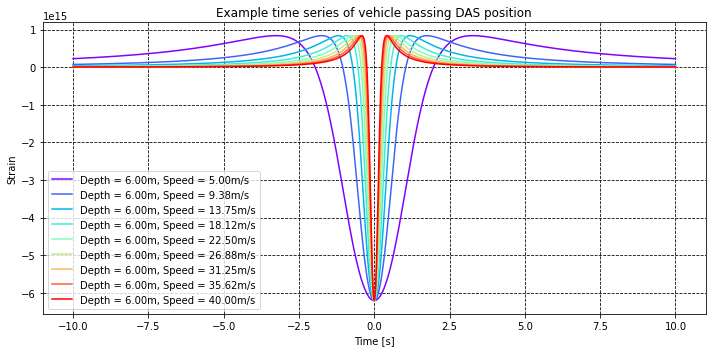

In [6]:
import numpy as np
import matplotlib.pyplot as plt
def plotTrace(t,exx,z,c,color='r'):
    import matplotlib.pyplot as plt
    plt.plot(t,exx,color=color,label='Depth = %.2fm, Speed = %.2fm/s' % (z,c))

nu = 0.4
E = 50e6
mu= E/(2*(1+nu)) 
t = np.linspace(-10,10,1000) # time vector, s
y = 3                      # offset distance from road to fiber, m
z = 6                      # vertical fiber depth, m
F = 1500/4

num = 9
c = np.linspace(5,40,num)                     # speed of vehicle, m/s
colors = plt.cm.rainbow(np.linspace(0,1,num))

fig,ax = plt.subplots(1,1,figsize=(10,5))

for i in range(num):
    x = c[i]*t 
    exx = fwdStrain(F,nu,E,component='xx',x=x,y=y,z=z,L=10)
    plotTrace(t,exx,z,c[i],color=colors[i]) 

plt.grid(color='k',linestyle='--')
plt.ylabel('Strain')
plt.xlabel('Time [s]')
plt.title('Example time series of vehicle passing DAS position')
legend = plt.legend()
legend.get_frame().set_facecolor('w')
plt.tight_layout()

A quick example for the horizontal DAS array pattern at one instant as a force passes for fibers at different depths

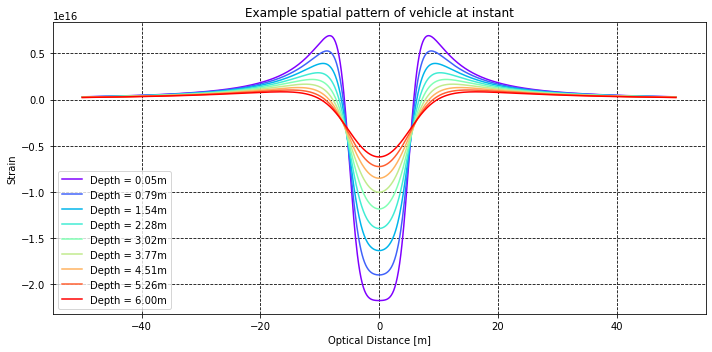

In [9]:
import numpy as np
import matplotlib.pyplot as plt
def plotTrace(x,exx,z,color='r'):
    import matplotlib.pyplot as plt
    plt.plot(x,exx,color=color,label='Depth = %.2fm' % (z))

nu = 0.4
E = 50e6
mu= E/(2*(1+nu)) 
x = np.linspace(-50,50,1000) # time vector, s
y = 3                      # offset distance from road to fiber, m
F = 1500/4

num = 9
z = np.linspace(0.05,6,num)                     # vertical fiber depth, m
colors = plt.cm.rainbow(np.linspace(0,1,num))

fig,ax = plt.subplots(1,1,figsize=(10,5))

for i in range(num):
    exx = fwdStrain(F,nu,E,component='xx',x=x,y=y,z=z[i],L=10)
    plotTrace(x,exx,z[i],color=colors[i]) 

plt.grid(color='k',linestyle='--')
plt.ylabel('Strain')
plt.xlabel('Optical Distance [m]')
plt.title('Example spatial pattern of vehicle at instant')
legend = plt.legend()
legend.get_frame().set_facecolor('w')
plt.tight_layout()
plt.savefig('depth.png')
plt.savefig('depth.pdf')


A quick example for the horizontal DAS array pattern at one instant as a force passes for fibers at different offsets

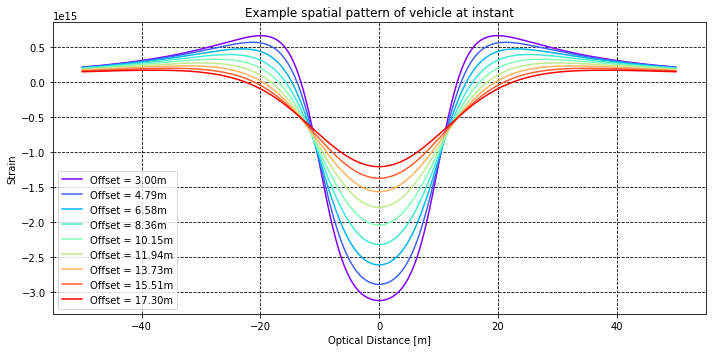

In [8]:
import numpy as np
import matplotlib.pyplot as plt
def plotTrace(x,exx,y,color='r'):
    import matplotlib.pyplot as plt
    plt.plot(x,exx,color=color,label='Offset = %.2fm' % (y))

nu = 0.44
E = 50e6
mu= E/(2*(1+nu)) 
x = np.linspace(-50,50,1000) # time vector, s
z = 6                      # vertical fiber depth, m
F = 1500/4

num = 9
# y = np.linspace(0,15,num)                      # offset distance from road to fiber, m
y = np.linspace(3,17.3,num) 
colors = plt.cm.rainbow(np.linspace(0,1,num))

fig,ax = plt.subplots(1,1,figsize=(10,5))

for i in range(num):
    exx = fwdStrain(F,nu,E,component='xx',x=x,y=y[i],z=z,L=20)
    plotTrace(x,exx,y[i],color=colors[i]) 

plt.grid(color='k',linestyle='--')
plt.ylabel('Strain')
plt.xlabel('Optical Distance [m]')
plt.title('Example spatial pattern of vehicle at instant')
legend = plt.legend()
legend.get_frame().set_facecolor('w')
plt.tight_layout()
plt.savefig('offset.png')
plt.savefig('offset.pdf')


A quick example for the horizontal DAS array pattern at one instant as different sized vehicles pass by

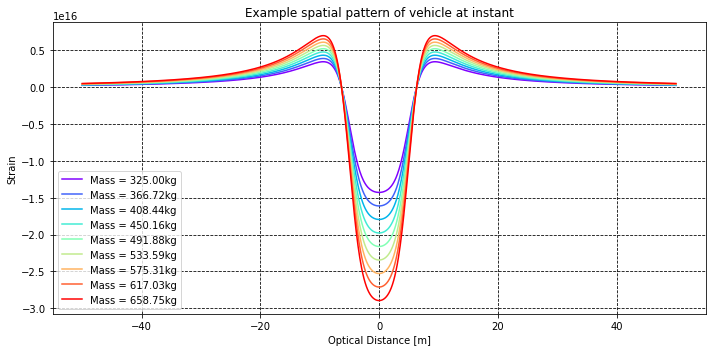

In [39]:
import numpy as np
import matplotlib.pyplot as plt
def plotTrace(x,exx,y,color='r'):
    import matplotlib.pyplot as plt
    plt.plot(x,exx,color=color,label='Mass = %.2fkg' % (y))

nu = 0.4
E = 50e6
mu= E/(2*(1+nu)) 
x = np.linspace(-50,50,1000) # time vector, s
z = 1.5                      # vertical fiber depth, m
y = 3                     # offset distance from road to fiber, m


num = 9
F = np.linspace(1300/4,2635/4,num) # 25% mass of civic --> suburban
colors = plt.cm.rainbow(np.linspace(0,1,num))

fig,ax = plt.subplots(1,1,figsize=(10,5))

for i in range(num):
    exx = fwdStrain(F[i],nu,E,component='xx',x=x,y=y,z=z,L=10)
    plotTrace(x,exx,F[i],color=colors[i]) 

plt.grid(color='k',linestyle='--')
plt.ylabel('Strain')
plt.xlabel('Optical Distance [m]')
plt.title('Example spatial pattern of vehicle at instant')
legend = plt.legend()
legend.get_frame().set_facecolor('w')
plt.tight_layout()

A quick example for the horizontal DAS array pattern at one instant for vehicles with varying gauge length

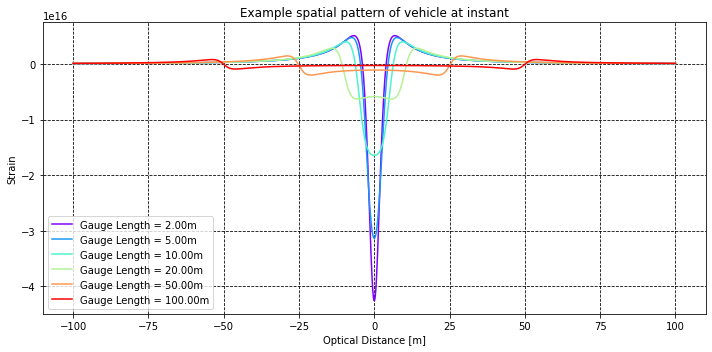

In [44]:
import numpy as np
import matplotlib.pyplot as plt
def plotTrace(x,exx,L,color='r'):
    import matplotlib.pyplot as plt
    plt.plot(x,exx,color=color,label='Gauge Length = %.2fm' % (L))

nu = 0.4
E = 50e6
mu= E/(2*(1+nu)) 
x = np.linspace(-100,100,1000) # time vector, s
z = 1.5                      # vertical fiber depth, m
y = 3                     # offset distance from road to fiber, m
F = 1500/4  # 25% mass of civic --> suburban

L = [2,5,10,20,50,100]
num = len(L)
colors = plt.cm.rainbow(np.linspace(0,1,num))
fig,ax = plt.subplots(1,1,figsize=(10,5))

for i in range(num):
    exx = fwdStrain(F,nu,E,component='xx',x=x,y=y,z=z,L=L[i])
    plotTrace(x,exx,L[i],color=colors[i]) 

plt.grid(color='k',linestyle='--')
plt.ylabel('Strain')
plt.xlabel('Optical Distance [m]')
plt.title('Example spatial pattern of vehicle at instant')
legend = plt.legend()
legend.get_frame().set_facecolor('w')
plt.tight_layout()